<a href="https://colab.research.google.com/github/davidballezaa/ai-datascience/blob/main/fastai/chapter_1/Is_it_a_duck_or_a_peacock%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
!pip install -Uqq fastai
from urllib.error import URLError,HTTPError
from fastcore.all import *
import json
import time

In [2]:
def search_images_ddg(term, max_images=30):
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]

In [14]:
# check if search is working
urls = search_images_ddg('duck photo', max_images=3)
urls[0]



'http://2.bp.blogspot.com/-j9rFDwz9CME/TrpKEA1NM3I/AAAAAAAADMA/LgeLoblmQAQ/s1600/baby-duck.jpg'

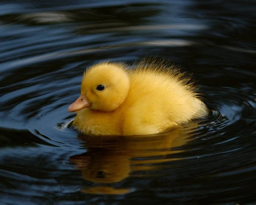

In [15]:
from fastdownload import download_url
dest = 'duck.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

In [5]:
searches = ['peacock', 'duck']
path = Path('peacock_or_duck')
from time import sleep

for query in searches:
  dest = (path/query)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images_ddg(f'{query} photo', max_images=60))
  sleep(5)
  download_images(dest, urls=search_images_ddg(f'{query} photo', max_images=60))
  resize_images(path/query, max_size=400, dest=path/query)


In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

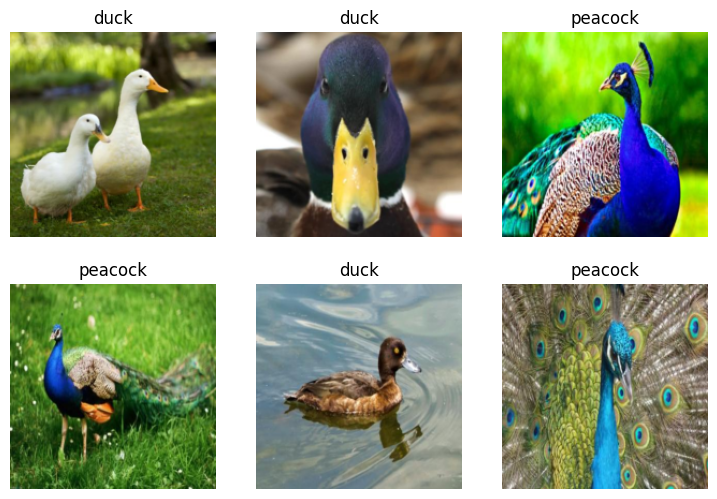

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.730244,0.004852,0.000000,00:05


epoch,train_loss,valid_loss,error_rate,time
0,0.065867,0.002312,0.000000,00:02
1,0.042019,0.000896,0.000000,00:02
2,0.027851,0.000146,0.000000,00:02


In [26]:
is_duck, _, probs = learn.predict(PILImage.create('duck.jpg'))
print(f"This is a: {is_duck}. ")
print(f"Probability it's a duck: {probs[0]:.4f}")
print(f"Probability it's a peacock: {probs[1]:.4f}")

This is a: duck. 
Probability it's a duck: 1.0000
Probability it's a peacock: 0.0000


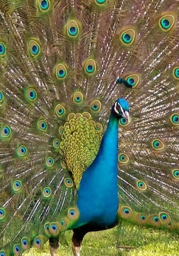

In [29]:
dest = 'peacock.jpg'
download_url(search_images_ddg('far distance peacock photo', 1)[0], dest, show_progress=False)
im = Image.open(dest)
im.to_thumb(256, 256)

In [30]:
is_duck, _, probs = learn.predict(PILImage.create('peacock.jpg'))
print(f"This is a: {is_duck}. ")
print(f"Probability it's a duck: {probs[0]:.4f}")
print(f"Probability it's a peacock: {probs[1]:.4f}")

This is a: peacock. 
Probability it's a duck: 0.0000
Probability it's a peacock: 1.0000
